## Summarize Model Performance

This notebook summarizes the relevant metrics on the test set. Note that the classes considered are:
- Bosmina
- Calanoid
- Chydoridae
- Chironomid
- Cyclopoid
- Daphnia
- Harpacticoid
- Other: Bubbles, Floc 1 & 2, LargeZ-1, Nauploo, Sididae, TooSmall

The model trains and predicts on each class individually. The "Other" category is created by merging the 7 classes into 1 class. Then, for an observation in any of those 7 classes, a prediction is considered to be a True Positive as long as it is one of those 7 classes.

#### SELECT MODEL ID / RUN NAME

In [29]:
# Corresponds to the desired model for displaying results

run_name = '20250627_150251_densenet121'
run_name = '20250705_131825_resnet50'
run_name = '20250705_140158_resnet50'

### Notebook & Data Set-Up

In [30]:
# Imports
import os
from collections import defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.metrics import *
from sklearn.preprocessing import label_binarize

In [31]:
# Paths
data_directory = '/data/zooplankton_data'
results_directory = '/home/bushra/Analysis_zooplankton/'

weights_path = os.path.join(results_directory, 'weights', run_name + '.pth')
predictions_path = os.path.join(results_directory, 'predictions', run_name + '.pth')
metadata_path = os.path.join(results_directory, 'environment', run_name + '.pth')

In [32]:
# Load predictions
predictions = torch.load(predictions_path, map_location = torch.device('cpu'))
y_true = predictions[0].numpy()
y_pred = predictions[2].numpy()
y_prob = predictions[1].numpy()

# Load environment/metadata variables
metadata = torch.load(metadata_path, weights_only = False)
model_id, model_name = metadata['model_id'], metadata['model_name']
classes, class_map = metadata['classes'], metadata['class_map']
train_metrics = metadata['train_metrics']
hyperparameters = metadata['hyperparameters']
# image_transforms = metadata['image_transforms']

In [33]:
# Define function to merge classes

def reorder_and_merge_classes(class_map, y_true, y_pred, y_prob, to_merge):

    class_map_rev = {v: k for k, v in class_map.items()} # Inverse class map

    # Create new class map with main classes + other
    to_keep = sorted([cls for cls in class_map if cls not in to_merge])
    new_class_map = {cls: idx for idx, cls in enumerate(to_keep)}

    other_index = len(to_keep)
    new_class_map['Other'] = other_index

    # Map old indices to new indices
    orig_max_index = max(class_map.values())
    orig_to_new_map = np.zeros(orig_max_index + 1, dtype = int)

    for orig_idx, cls in class_map_rev.items():
        if cls in to_merge:
            orig_to_new_map[orig_idx] = other_index
        else:
            orig_to_new_map[orig_idx] = new_class_map[cls]

    # Map labels
    new_y_true = orig_to_new_map[y_true]
    new_y_pred = orig_to_new_map[y_pred]

    # Map prediction probabilities
    n_samples = y_prob.shape[0]
    new_n_classes = len(new_class_map)
    new_y_prob = np.zeros((n_samples, new_n_classes))
    
    for orig_idx, cls in class_map_rev.items():
        new_idx = new_class_map['Other'] if cls in to_merge else new_class_map[cls]
        new_y_prob[:, new_idx] += y_prob[:, orig_idx]

    # Need to normalize due to floating-point precision
    y_prob_sums = new_y_prob.sum(axis = 1, keepdims = True)
    new_y_prob = new_y_prob / y_prob_sums

    return new_class_map, new_y_true, new_y_pred, new_y_prob

In [34]:
# Merge classes
to_merge = ['Bubbles', 'Floc_1', 'Floc_2', 'LargeZ-1', 'Nauplii', 'Sididae', 'TooSmall']

class_map, y_true, y_pred, y_prob = reorder_and_merge_classes(class_map, y_true, y_pred, y_prob, to_merge)
class_map_rev = {v: k for k, v in class_map.items()}
classes = list(class_map.keys())

### Model Train Parameters

In [35]:
print(f'Selected Model: {model_name} (ID: {model_id})')
print('\nClasses:\n ' + '\n '.join(f'{cln}: {clid}' for cln, clid in class_map.items())) # New classes, but model trained on orig classes
print('\nTraining Parameters:\n ' + '\n '.join(f'{p}: {pv}' for p, pv in hyperparameters.items()))

Selected Model: resnet50 (ID: 20250705_140158)

Classes:
 Bosmina_1: 0
 Calanoid_1: 1
 Chironomid: 2
 Chydoridae: 3
 Cyclopoid_1: 4
 Daphnia: 5
 Herpacticoida: 6
 Other: 7

Training Parameters:
 loss_fn: {'type': 'CrossEntropyLoss', 'weights': tensor([0.0712, 0.0712, 0.0712, 0.0713, 0.0721, 0.0712, 0.0714, 0.0712, 0.0723,
        0.0713, 0.0712, 0.0714, 0.0715, 0.0712])}
 optimizer: Adam
 lr: 0.0001
 epochs: 50
 scheduler: {'type': 'StepLR', 'step_size': 10, 'gamma': 0.1}
 early_stopping: {'patience': 15, 'delta': 0.005}
 batch_size: 64


### Overall Test Metrics

In [36]:
# Compute overall metrics
acc = accuracy_score(y_true, y_pred)

prec_avg = precision_score(y_true, y_pred, average = 'macro')
prec_w_avg = precision_score(y_true, y_pred, average = 'weighted')

recall_avg = recall_score(y_true, y_pred, average = 'macro')
recall_w_avg = recall_score(y_true, y_pred, average = 'weighted')

f1_avg = f1_score(y_true, y_pred, average = 'macro')
f1_w_avg = f1_score(y_true, y_pred, average = 'weighted')

ce = log_loss(y_true, y_prob)

In [37]:
# Print
print(f'Accuracy: {acc:.4f}\n')
print(f'Average Precision: {prec_avg:.4f}\nWeighted Precision: {prec_w_avg:.4f}\n')
print(f'Average Recall: {recall_avg:.4f}\nWeighted Recall: {recall_w_avg:.4f}\n')
print(f'Average F1: {f1_avg:.4f}\nWeighted F1: {f1_w_avg:.4f}\n')
print(f'Cross Entropy: {ce:.4f}')

Accuracy: 0.9660

Average Precision: 0.8865
Weighted Precision: 0.9657

Average Recall: 0.8237
Weighted Recall: 0.9660

Average F1: 0.8404
Weighted F1: 0.9656

Cross Entropy: 0.1108


### Per Class Metrics

In [38]:
# Compute per class metrics

prec_per_class = precision_score(y_true, y_pred, average = None)
recall_per_class = recall_score(y_true, y_pred, average = None)

# Cross-entropy
y_true_tensor = torch.from_numpy(y_true).long()
y_logit_tensor = torch.from_numpy(y_prob).float().log()

ce_all = F.cross_entropy(y_logit_tensor, y_true_tensor, reduction = 'none')
class_ces = defaultdict(list)

for ce, y in zip(ce_all, y_true_tensor):
    class_ces[int(y)].append(ce.item())

ce_per_class = np.full(len(classes), np.nan)
for clid in range(len(classes)):
    if class_ces[clid]:
        ce_per_class[clid] = np.mean(class_ces[clid])

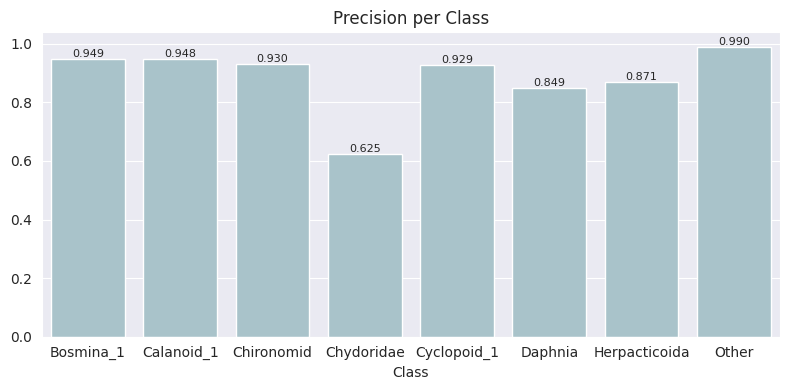

In [39]:
# Plot precision per class
sns.set_style('darkgrid')
plt.figure(figsize=(8,4))

ax = sns.barplot(x = classes, y = prec_per_class, color = '#a3c6cf')
plt.title('Precision per Class')
plt.xlabel('Class')
ax.bar_label(ax.containers[0], fmt = '%.3f', fontsize = 8)

plt.tight_layout()
plt.show()

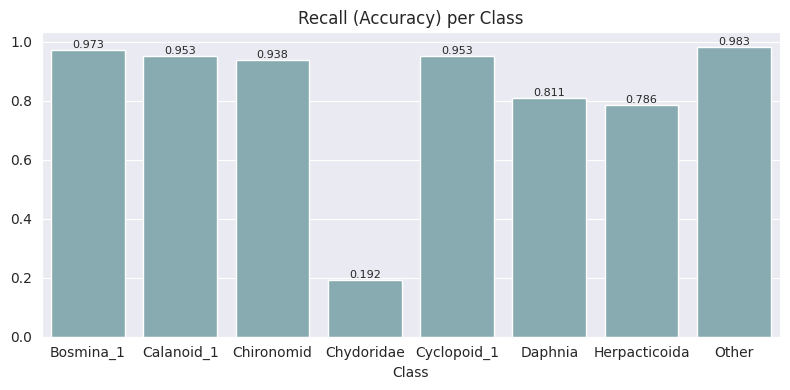

In [40]:
# Plot recall (aka accuracy) per class
sns.set_style('darkgrid')
plt.figure(figsize=(8,4))

ax = sns.barplot(x = classes, y = recall_per_class, color = '#80b0b8')
plt.title('Recall (Accuracy) per Class')
plt.xlabel('Class')
ax.bar_label(ax.containers[0], fmt = '%.3f', fontsize = 8)

plt.tight_layout()
plt.show()

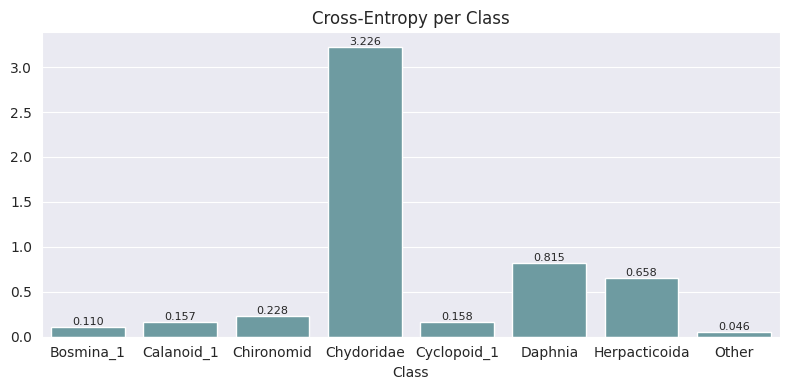

In [41]:
# Plot cross-entropy per class
sns.set_style('darkgrid')
plt.figure(figsize=(8,4))

ax = sns.barplot(x = classes, y = ce_per_class, color = '#66a2a9')
plt.title('Cross-Entropy per Class')
plt.xlabel('Class')
ax.bar_label(ax.containers[0], fmt = '%.3f', fontsize = 8)

plt.tight_layout()
plt.show()

### Confusion Matrix

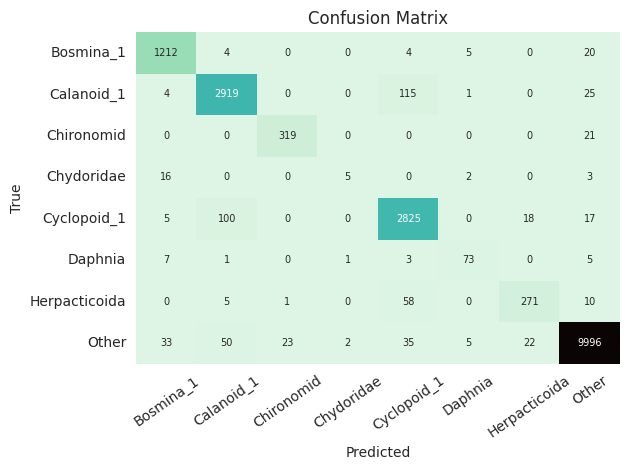

In [42]:
# Get confusion matrix data
cm = confusion_matrix(y_true, y_pred)
annot_kws = {'size': 7}

# Plot
sns.heatmap(cm, annot = True, annot_kws = annot_kws, fmt = 'd', cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation = 35)

plt.tight_layout()
plt.show()